# **Initial Load**

Authenticate with Google Drive and read in our dataset.

In [ ]:
# Install any required packages.
!pip install -U -q PyDrive
!pip install -U -q shap

In [ ]:
# Import any required libraries.
from google.colab import auth
from patsy import dmatrices
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

In [ ]:
# Authenticate with Google Drive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from itertools import combinations
import plotly.express as px

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import chi2_contingency, pearsonr, spearmanr

from sklearn.metrics import accuracy_score, recall_score, precision_score, multilabel_confusion_matrix,confusion_matrix,f1_score,roc_auc_score

from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV


from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, chi2

import shap

In [ ]:
# Download our dataset from Google Drive.
downloaded_file = drive.CreateFile({ 'id': '14RMV7CRXwwCt_9iLHenyQrB9GC5gYwul' })
downloaded_file.GetContentFile('ChicagoCrimeRecords.csv')
chicago_crime_records = pd.read_csv('ChicagoCrimeRecords.csv')

In [ ]:
# Clear the downloaded file and all other variables from memory, once we've converted it to a data frame.
del downloaded_file, drive, gauth

# **Pre-Processing the data**



In [ ]:
#Drop duplicates if there are any
chicago_crime_records.drop_duplicates(inplace=True)

In [ ]:
# Take a look at all of the columns in our dataset.
chicago_crime_records.columns.sort_values()

Index(['Arrest', 'Beat', 'Block', 'Case Number', 'Community Area', 'Date',
       'Description', 'District', 'Domestic', 'FBI Code', 'ID', 'IUCR',
       'Latitude', 'Location', 'Location Description', 'Longitude',
       'Primary Type', 'Updated On', 'Ward', 'X Coordinate', 'Y Coordinate',
       'Year'],
      dtype='object')

In [ ]:
chicago_crime_records.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [ ]:
chicago_crime_records['Primary Type'].nunique()

36

In [ ]:
chicago_crime_records['Date'].head()

0    09/05/2015 01:30:00 PM
1    09/04/2015 11:30:00 AM
2    09/01/2018 12:01:00 AM
3    09/05/2015 12:45:00 PM
4    09/05/2015 01:00:00 PM
Name: Date, dtype: object

In [ ]:
# Randomly sample our dataset, so that it is small enough to work with.
df_ccr = chicago_crime_records.sample(100000, random_state = 117)

In [ ]:
#Dropping Null values because it doesn't impact the result and helps for the computation and RAM
df_ccr.dropna(inplace=True)

In [ ]:
daysOfTheWeek={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

In [ ]:
# Create a new feature for the weekday, month, and hour on in, or on which the crime occurred.
df_ccr.Date=pd.to_datetime(df_ccr.Date)
df_ccr["Weekday"] = df_ccr.Date.map(lambda x: daysOfTheWeek[x.weekday()])
df_ccr["Month"] = df_ccr.Date.dt.month
df_ccr["Hour"] = df_ccr.Date.dt.hour + df_ccr.Date.dt.minute/60

In [ ]:
# Remove any features that we are confident will not be of any use to our model.
df_ccr.drop(
    columns = [
        'Arrest',        # Occurs after the crime has been classified.
        'Case Number',   # Assigned after the crime has occurred.
        'Date',          # Replaced by 'Weekday', 'Month' and 'Hour'.
        'Description',   # A more granular version of 'Primary Type'.
        'FBI Code',      # An encoded form of 'Primary Type'.
        'Location',      # Replace by 'Latitude', 'Longitude', 'X Coordinate', 'Y Coordinate'.
        'ID',            # Provides zero insight into the crime as it is simply an index for each row.
        'IUCR',          # An encoded form of 'Primary Type'.
        'Updated On'],   # Updated after the crime has already been recorded.
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [ ]:
# Take a look at all of the columns left in our dataset.
df_ccr.columns.sort_values()

Index(['Beat', 'Block', 'Community Area', 'District', 'Domestic', 'Hour',
       'Latitude', 'Location Description', 'Longitude', 'Month',
       'Primary Type', 'Ward', 'Weekday', 'X Coordinate', 'Y Coordinate',
       'Year'],
      dtype='object')

In [ ]:
sample_num_class=df_ccr['Primary Type'].nunique()
sample_num_class

32

FixedFormatter should only be used together with FixedLocator


[Text(0.0, 0, '0'),
 Text(2000.0, 0, '2000'),
 Text(4000.0, 0, '4000'),
 Text(6000.0, 0, '6000'),
 Text(8000.0, 0, '8000'),
 Text(10000.0, 0, '10000'),
 Text(12000.0, 0, '12000'),
 Text(14000.0, 0, '14000'),
 Text(16000.0, 0, '16000')]

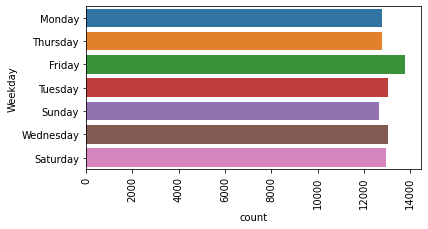

In [ ]:
# Print Crime Counts per Weekday
plt.figure(figsize=(6,3))
ax = sns.countplot(y = df_ccr['Weekday'], orient='h')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

A bit more crime on Fridays

In [ ]:
# Extracting Street Types
df_ccr['Is_ST'] = df_ccr['Block'].str.contains(" ST", case=True)
df_ccr['Is_AV'] = df_ccr['Block'].str.contains(" AV", case=True)
df_ccr['Is_TR'] = df_ccr['Block'].str.contains(" TR", case=True)
df_ccr['Is_DR'] = df_ccr['Block'].str.contains(" DR", case=True)

In [ ]:
df_ccr.head(10)

,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Weekday,Month,Hour,Is_ST,Is_AV,Is_TR,Is_DR
2367150,014XX S KEDVALE AVE,NARCOTICS,STREET,False,1011,10.0,24.0,29.0,1148953.0,1892691.0,2003,41.861474,-87.728701,Monday,10,20.750000,False,True,False,False
3615589,042XX S PRAIRIE AVE,PROSTITUTION,STREET,False,214,2.0,3.0,38.0,1178742.0,1877055.0,2006,41.817940,-87.619829,Thursday,7,20.250000,False,True,False,False
3091184,048XX W MONROE ST,GAMBLING,OTHER,False,1533,15.0,28.0,25.0,1144208.0,1899225.0,2005,41.879494,-87.745955,Thursday,4,13.583333,True,False,False,False
2901992,024XX N CLARK ST,CRIMINAL DAMAGE,GROCERY FOOD STORE,False,2333,19.0,43.0,7.0,1172680.0,1916483.0,2005,41.926269,-87.640899,Friday,1,23.500000,True,False,False,False
2228399,113XX S EDBROOKE AVE,CRIM SEXUAL ASSAULT,RESIDENCE,False,531,5.0,9.0,49.0,1179225.0,1829737.0,2003,41.688083,-87.619497,Thursday,5,21.550000,False,True,False,False
4361824,021XX W FOSTER AVE,NARCOTICS,SIDEWALK,False,2032,20.0,47.0,4.0,1161233.0,1934513.0,2008,41.975990,-87.682458,Tuesday,5,16.666667,False,True,False,False
3446671,015XX S SAWYER AVE,CRIMINAL DAMAGE,STREET,False,1022,10.0,24.0,29.0,1154945.0,1892332.0,2006,41.860371,-87.706715,Sunday,3,5.000000,False,True,False,False
6686449,022XX W GRANVILLE AVE,BURGLARY,APARTMENT,False,2413,24.0,50.0,2.0,1160452.0,1941133.0,2014,41.994172,-87.685146,Thursday,6,6.833333,False,True,False,False
2774442,076XX S DREXEL AVE,BATTERY,RESIDENCE PORCH/HALLWAY,False,624,6.0,8.0,69.0,1183558.0,1854454.0,2004,41.755809,-87.602867,Friday,9,2.250000,False,True,False,True
515580,131XX S FORRESTVILLE AVE,OTHER OFFENSE,STREET,False,533,5.0,9.0,54.0,1182311.0,1818405.0,2017,41.656915,-87.608549,Wednesday,6,10.000000,False,True,False,False


In [ ]:
# Test for multicollinearity between our nominal categorical features using a chi² test of independence.
nominal_features = [
    'Beat',
    'Block',
    'Community Area',
    'District',
    'Domestic',
    'Location Description',
    'Is_ST',
    'Is_AV',
    'Is_DR',
    'Is_TR']

for pair in list(combinations(nominal_features, 2)):
  test_result = chi2_contingency(pd.crosstab(df_ccr[pair[0]], df_ccr[pair[1]]))
  if test_result.pvalue>=0.05:
    print(f"{pair[0]} + {pair[1]}: Independent")
  #print(f"{pair[0]} + {pair[1]}: {'(Correlated)' if test_result.pvalue < 0.05 else '(Independent)'}")

Domestic + Is_DR: Independent
Is_AV + Is_TR: Independent


In [ ]:
# Test for multicollinearity between our ordinal categorical features using the Spearman rank correlation coefficient.
ordinal_features = [
    'Hour',
    'Month',
    'Weekday',
    'Year']

for pair in list(combinations(ordinal_features, 2)):
  spearman_coefficient, p_value = spearmanr(df_ccr[pair[0]], df_ccr[pair[1]])
  print(f"{pair[0]} + {pair[1]}: {'(Correlated)' if p_value < 0.05 else '(Independent)'}")
  print(f"Spearman Coefficient: {spearman_coefficient}\n")

Hour + Month: (Independent)
Spearman Coefficient: -4.5167366456872866e-05

Hour + Weekday: (Independent)
Spearman Coefficient: 0.0018255807325024585

Hour + Year: (Correlated)
Spearman Coefficient: -0.02612847134614103

Month + Weekday: (Independent)
Spearman Coefficient: -0.0005956929786704653

Month + Year: (Correlated)
Spearman Coefficient: -0.03736240481084049

Weekday + Year: (Independent)
Spearman Coefficient: -0.005088122827407889



In [ ]:
numerical_features = [
    'Latitude',
    'Longitude',
    'X Coordinate',
    'Y Coordinate']

for pair in list(combinations(numerical_features, 2)):
  pearson_coefficient, p_value = pearsonr(df_ccr[pair[0]], df_ccr[pair[1]])
  print(f"{pair[0]} + {pair[1]}:{'(Correlated)' if p_value < 0.05 else '(Independent)'}")
  print(f"Pearson Coefficient: {pearson_coefficient}\n")

Latitude + Longitude:(Correlated)
Pearson Coefficient: -0.3615605016225117

Latitude + X Coordinate:(Correlated)
Pearson Coefficient: -0.3615259730780126

Latitude + Y Coordinate:(Correlated)
Pearson Coefficient: 0.9999929649098258

Longitude + X Coordinate:(Correlated)
Pearson Coefficient: 0.9997532197504095

Longitude + Y Coordinate:(Correlated)
Pearson Coefficient: -0.36028656632577405

X Coordinate + Y Coordinate:(Correlated)
Pearson Coefficient: -0.36032950136697617



In [ ]:
# Remove some of our numerical features, in accordance with the results of the pearson correlation test above.
df_ccr.drop(
    columns = [
        'Latitude',     # Is highly correlated with 'Y Coordinate'.
        'Longitude'],   # Is highly correlated with 'X Coordinate'.
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [ ]:

#Putting our coordinates from polar to carthesian values
# Processing Function for Features
def cart2polar(x, y):
    dist = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return dist, phi
dist, phi = cart2polar(df_ccr['X Coordinate'], df_ccr['Y Coordinate'])

In [ ]:
df_ccr['Y Coordinate']

2367150    1892691.0
3615589    1877055.0
3091184    1899225.0
2901992    1916483.0
2228399    1829737.0
             ...    
4454481    1904058.0
4433606    1847777.0
4886621    1903439.0
5596188    1850549.0
6833305    1833653.0
Name: Y Coordinate, Length: 91034, dtype: float64

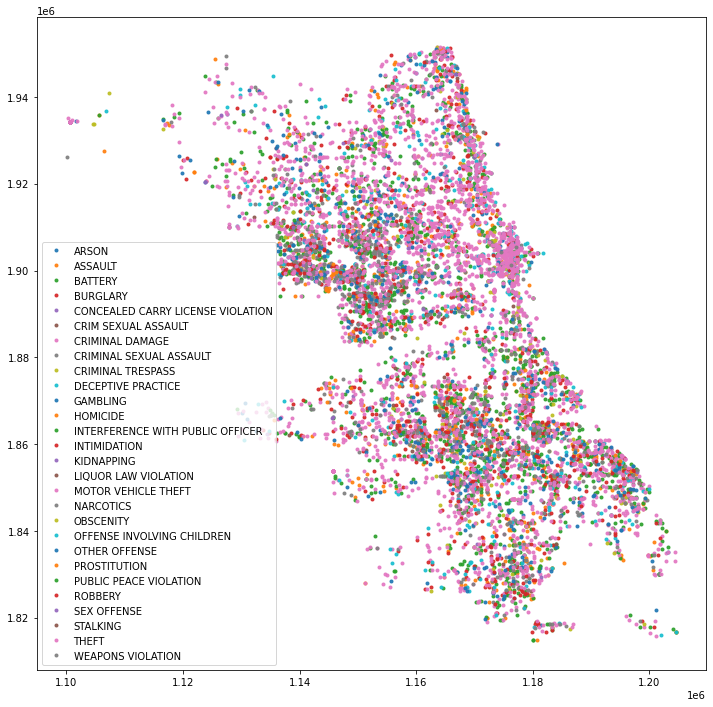

In [ ]:
sampleshow=df_ccr.sample(frac=0.1)

groups = sampleshow.groupby('Primary Type')

fig, ax = plt.subplots(sharex=False, figsize=(12, 12))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['X Coordinate'], group['Y Coordinate'], marker='.', linestyle='', label=name, alpha=0.9)
ax.legend()
plt.show()

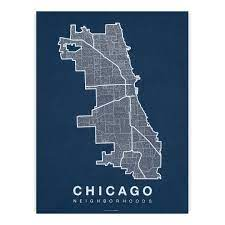

We can get an idea of how the crime is spread through the city

In [ ]:
### We have some errors in the coordinates
df_ccr[df_ccr['X Coordinate']==0]

,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Weekday,Month,Hour,Is_ST,Is_AV,Is_TR,Is_DR
5430005,035XX W 54TH PL,PUBLIC PEACE VIOLATION,"SCHOOL, PUBLIC, BUILDING",False,822,8.0,14.0,63.0,0.0,0.0,2011,Monday,1,12.883333,False,False,False,False
6784744,019XX S CANALPORT AVE,THEFT,SIDEWALK,False,1235,12.0,25.0,31.0,0.0,0.0,2014,Wednesday,10,17.000000,False,True,False,False
7410549,023XX W GRAND AVE,CRIMINAL DAMAGE,VEHICLE NON-COMMERCIAL,False,1313,12.0,26.0,24.0,0.0,0.0,2008,Tuesday,8,1.416667,False,True,False,False


In [ ]:
#dropping these error
df_ccr.drop(df_ccr[df_ccr['X Coordinate']==0].index,inplace=True)

In [ ]:
#Block column to category
df_ccr['Block'] = df_ccr['Block'].astype('category')

In [ ]:
df=df_ccr.copy()

In [ ]:
#One  Hot Encode the days
WeekdayOHE=pd.get_dummies(df[['Weekday','Location Description']])
df=pd.concat([WeekdayOHE,df], axis=1,join='inner')

In [ ]:
df.drop(columns=['Weekday','Location Description'],inplace=True)

In [ ]:
dfnoBlock=df.copy()
dfnoBlock.drop(columns=['Block','Beat','District','Ward','Community Area'],inplace=True)

In [ ]:
# Create a new feature, denoting whether or not a specific crime occurred.
crime_to_predict = 'Theft'
dfnoBlock[crime_to_predict] = 0
dfnoBlock.loc[dfnoBlock['Primary Type'] == crime_to_predict.upper(), crime_to_predict] = 1

In [ ]:
dfnoBlock.head()

,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Location Description_ABANDONED BUILDING,Location Description_AIRCRAFT,Location Description_AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,...,X Coordinate,Y Coordinate,Year,Month,Hour,Is_ST,Is_AV,Is_TR,Is_DR,Theft
2367150,0,1,0,0,0,0,0,0,0,0,...,1148953.0,1892691.0,2003,10,20.750000,False,True,False,False,0
3615589,0,0,0,0,1,0,0,0,0,0,...,1178742.0,1877055.0,2006,7,20.250000,False,True,False,False,0
3091184,0,0,0,0,1,0,0,0,0,0,...,1144208.0,1899225.0,2005,4,13.583333,True,False,False,False,0
2901992,1,0,0,0,0,0,0,0,0,0,...,1172680.0,1916483.0,2005,1,23.500000,True,False,False,False,0
2228399,0,0,0,0,1,0,0,0,0,0,...,1179225.0,1829737.0,2003,5,21.550000,False,True,False,False,0


In [ ]:
print(len(df.columns))

170


In [ ]:
Y_target=dfnoBlock['Theft']

# Test Train Data

In [ ]:
X_df=dfnoBlock.drop(columns=['Primary Type','Theft'])

In [ ]:
# Synthesise new examples using SMOTE and undersampling.
oversampler = SMOTE(k_neighbors = 3)
undersampler = RandomUnderSampler()
pipeline = Pipeline(steps= [('o', oversampler), ('u', undersampler)])
X_df, Y_target = pipeline.fit_resample(X_df, Y_target)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_df, Y_target, test_size=0.2, random_state=0)

#Tuning the model

#Fitting the XGBoost model

In [ ]:
# Configure the XGBoost model
xgb_clf = XGBClassifier(objective='binary:logistic',learning_rate=0.3,eval_metric='error',min_split_loss=0.1,predictor='auto',tree_method='auto')
xgb_clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_split_loss=0.1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor='auto', ...)

In [ ]:
#objective='binary:logistic',learning_rate=0.3,eval_metric='error',min_split_loss=0.1,predictor='auto'
y_pred = xgb_clf.predict(x_test)
print("Accuracy : ",accuracy_score(y_test, y_pred))
print("Recall : ", recall_score(y_test, y_pred,average='macro'))
print("Precision : ", precision_score(y_test, y_pred,average='macro'))
print("F1 score : ",f1_score(y_test,y_pred))
print("ROC AUC score : ", roc_auc_score(y_test,y_pred))

Accuracy :  0.8700396135937174
Recall :  0.870552303797171
Precision :  0.8763868128873049
F1 score :  0.8619722468260997
ROC AUC score :  0.870552303797171


In [ ]:
#objective='binary:logistic',learning_rate=0.3,eval_metric='error',min_split_loss=0.1,predictor='auto',tree_method='auto'
y_pred = xgb_clf.predict(x_test)
print("Accuracy : ",accuracy_score(y_test, y_pred))
print("Recall : ", recall_score(y_test, y_pred,average='macro'))
print("Precision : ", precision_score(y_test, y_pred,average='macro'))
print("F1 score : ",f1_score(y_test,y_pred))
print("ROC AUC score : ", roc_auc_score(y_test,y_pred))

Accuracy :  0.8700396135937174
Recall :  0.870552303797171
Precision :  0.8763868128873049
F1 score :  0.8619722468260997
ROC AUC score :  0.870552303797171


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


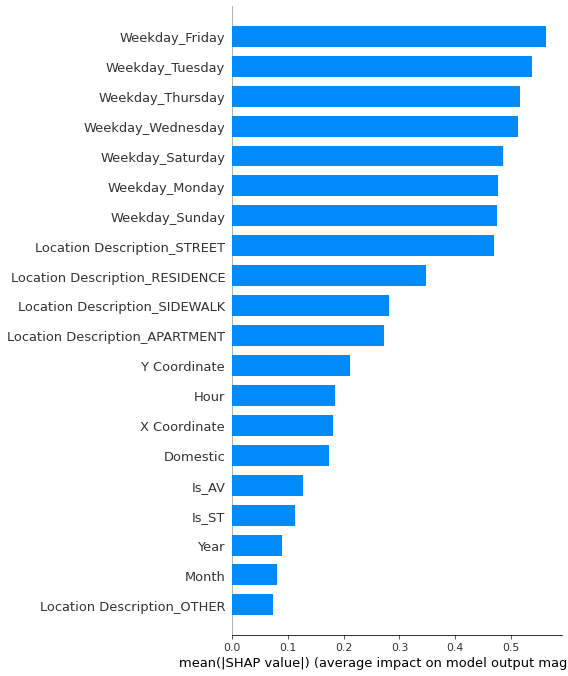

In [ ]:
# Calculate and display the Shapley additive explanations for our model.
shap_values = shap.Explainer(xgb_clf).shap_values(x_train)
#shap.plots.bar(shap_values)
shap.summary_plot(shap_values, x_test, plot_type="bar")

# Hyperparamter Tuning using GridsearchCV

In [ ]:
#Tuning the hyper Parameters
param_grid = {
              'learning_rate':[0.01,0.05,0.3],
              'min_split_loss':[0.1,0.5,0.7],
              'predictor':['auto','cpu_predictor'],
              'eval_metric':['error','mlogloss','f1','rmse'],
              'tree_method':["auto", "approx", "hist"],      
              'importance_type' : ['weight', 'gain', 'cover']
              }

grid = GridSearchCV(XGBClassifier(objective='binary:logistic'), param_grid)
grid.fit(x_train, y_train)

print(grid.best_params_) # Best parameters apparently
modelXGBgrid = grid.best_estimator_ #put parameters into model
modelXGBgrid.score(x_test,y_test) # score the model